# Análisis de Diagramas Color-Color con SPLUS+WISE

Este notebook permite visualizar diagramas color-color utilizando datos combinados de SPLUS y WISE. Además, permite dibujar, mover y eliminar líneas en los gráficos, y calcular sus pendientes e interceptos.

In [2]:
%matplotlib widget
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, NullFormatter
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

# Función para abrir y concatenar archivos CSV
def open_csv_conc(pattern, exclude_pattern):
    csv_files = glob.glob(pattern)
    csv_files = [file for file in csv_files if exclude_pattern not in file]
    dfs = []

    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Cargar datos
df_splus_wise = open_csv_conc("../Class_wise_main_unique/*.csv", "simbad")

print("Number of objects just with SPLUS+WISE colors:", len(df_splus_wise))

# Definir colores basados en el número de etiquetas
num_colors = len(df_splus_wise["Label"].unique())
colors = sns.color_palette("tab10", num_colors)
edge_colors = sns.color_palette("dark", num_colors)  # Definir colores de borde

# Función para calcular la pendiente y el intercepto
def calculate_slope_intercept(x1, y1, x2, y2):
    if x1 == x2:
        m = np.inf
        b = np.nan
    else:
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
    return m, b

# Función para manejar eventos de clic y arrastre
def on_click_factory(ax, text_area, delete_button):
    points = []
    line_count = 0
    lines = []
    selected_line = None
    selected_point_index = None
    dragging = False

    def on_click(event):
        nonlocal line_count, selected_line, selected_point_index, dragging
        if event.inaxes == ax:
            if selected_line is not None and selected_point_index is not None:
                dragging = True
            else:
                points.append((event.xdata, event.ydata))
                if len(points) == 2:
                    x1, y1 = points[0]
                    x2, y2 = points[1]
                    m, b = calculate_slope_intercept(x1, y1, x2, y2)
                    line_count += 1
                    line_label = f'Linea{line_count}'
                    line, = ax.plot([x1, x2], [y1, y2], marker='o', color='black', picker=5)
                    line.set_label(line_label)
                    lines.append(line)
                    ax.text((x1 + x2) / 2, (y1 + y2) / 2, line_label, fontsize=12, color='black')
                    plt.draw()
                    text_area.value += f'{line_label} = Pendiente: {m:.6f}, Intercepto: {b:.6f}\n'
                    points.clear()

    def on_pick(event):
        nonlocal selected_line, selected_point_index
        artist = event.artist
        if artist in lines:
            if selected_line is artist:
                selected_line.set_color('black')
                selected_line = None
                selected_point_index = None
            else:
                if selected_line is not None:
                    selected_line.set_color('black')
                selected_line = artist
                selected_point_index = event.ind[0]
                artist.set_color('red')
            plt.draw()

    def on_motion(event):
        nonlocal dragging, selected_line, selected_point_index
        if dragging and selected_line is not None and selected_point_index is not None:
            if event.inaxes == ax:
                xdata, ydata = selected_line.get_xdata(), selected_line.get_ydata()
                xdata[selected_point_index] = event.xdata
                ydata[selected_point_index] = event.ydata
                selected_line.set_xdata(xdata)
                selected_line.set_ydata(ydata)
                plt.draw()

    def on_release(event):
        nonlocal dragging, selected_line, selected_point_index
        if dragging and selected_line is not None and selected_point_index is not None:
            xdata, ydata = selected_line.get_xdata(), selected_line.get_ydata()
            x1, y1 = xdata[0], ydata[0]
            x2, y2 = xdata[1], ydata[1]
            m, b = calculate_slope_intercept(x1, y1, x2, y2)
            line_label = selected_line.get_label()
            text_area.value += f'{line_label} (Updated) = Pendiente: {m:.6f}, Intercepto: {b:.6f}\n'
            dragging = False

    def on_delete(event):
        nonlocal selected_line
        if selected_line is not None:
            for text in ax.texts:
                if text.get_text() == selected_line.get_label():
                    text.remove()
            selected_line.remove()
            lines.remove(selected_line)
            text_area.value += f'{selected_line.get_label()} (Deleted)\n'
            plt.draw()
            selected_line = None

    delete_button.on_click(on_delete)

    return on_click, on_pick, on_motion, on_release

def plot_color_color_diagram(pair):
    ((x1, y1), (x2, y2)) = pair
    fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

    for group, (label, group_data) in enumerate(df_splus_wise.groupby("Label")):
        legend_label = "Noise" if label == -1 else f"Group {label}"
        color = colors[group % num_colors]
        edge_color = edge_colors[group % num_colors]
        marker = 'o'

        ax.scatter(group_data[x1] - group_data[y1], group_data[x2] - group_data[y2],
                   c=[color], s=10, marker=marker, edgecolors=[edge_color], linewidth=0.5, label=legend_label, alpha=0.7)

    xlabel = x1.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ylabel = y1.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ax.set_xlabel(f"{xlabel} - {ylabel}", fontsize=12)

    xlabel = x2.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ylabel = y2.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ax.set_ylabel(f"{xlabel} - {ylabel}", fontsize=12, labelpad=10)

    ax.tick_params(axis='both', labelsize=10)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.set_aspect('auto')

    text_area = widgets.Textarea(
        value='',
        placeholder='Pendientes e interceptos de las líneas dibujadas aparecerán aquí...',
        description='Resultados:',
        layout=widgets.Layout(width='100%', height='100px'),
        disabled=False
    )
    display(text_area)

    delete_button = widgets.Button(
        description='Delete Line',
        disabled=False,
        button_style='danger',
        tooltip='Delete selected line',
        icon='trash'
    )
    display(delete_button)

    on_click, on_pick, on_motion, on_release = on_click_factory(ax, text_area, delete_button)
    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.canvas.mpl_connect('pick_event', on_pick)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)
    fig.canvas.mpl_connect('button_release_event', on_release)

    plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

## Ejemplo de Uso

Para utilizar la función y crear los gráficos de los pares específicos, ejecuta las siguientes celdas:

```python
plot_color_color_diagram((('W2mag', 'r_PStotal'), ('J0378_PStotal', 'J0430_PStotal')))
plot_color_color_diagram((('J0395_PStotal', 'J0430_PStotal'), ('W2mag', 'i_PStotal')))
plot_color_color_diagram((('i_PStotal', 'z_PStotal'), ('W2mag', 'z_PStotal')))
plot_color_color_diagram((('u_PStotal', 'J0430_PStotal'), ('W1mag', 'W2mag')))
plot_color_color_diagram((('g_PStotal', 'u_PStotal'), ('W1mag', 'i_PStotal')))
plot_color_color_diagram((('W2mag', 'g_PStotal'), ('g_PStotal', 'J0378_PStotal')))
plot_color_color_diagram((('J0430_PStotal', 'J0515_PStotal'), ('i_PStotal', 'J0861_PStotal')))
plot_color_color_diagram((('W1mag', 'z_PStotal'), ('z_PStotal', 'J0660_PStotal')))
plot_color_color_diagram((('W1mag', 'r_PStotal'), ('r_PStotal', 'J0378_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

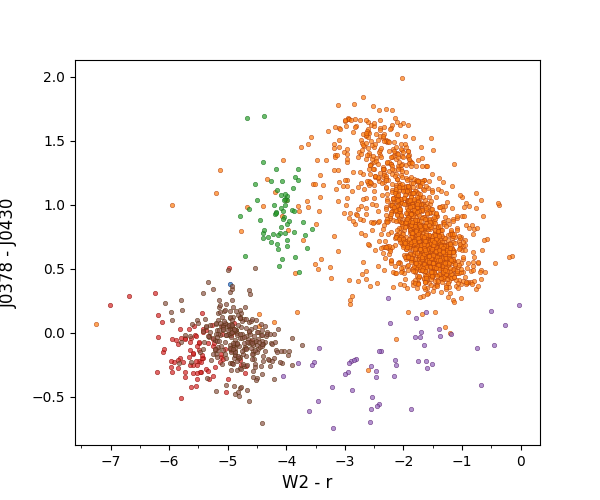

In [15]:
plot_color_color_diagram((('W2mag', 'r_PStotal'), ('J0378_PStotal', 'J0430_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

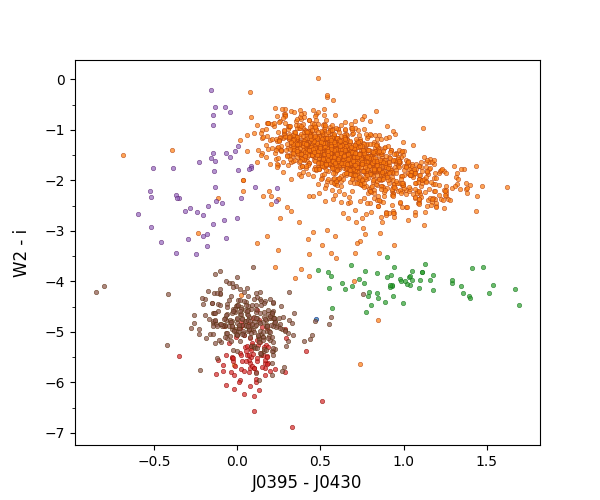

In [3]:
plot_color_color_diagram((('J0395_PStotal', 'J0430_PStotal'), ('W2mag', 'i_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

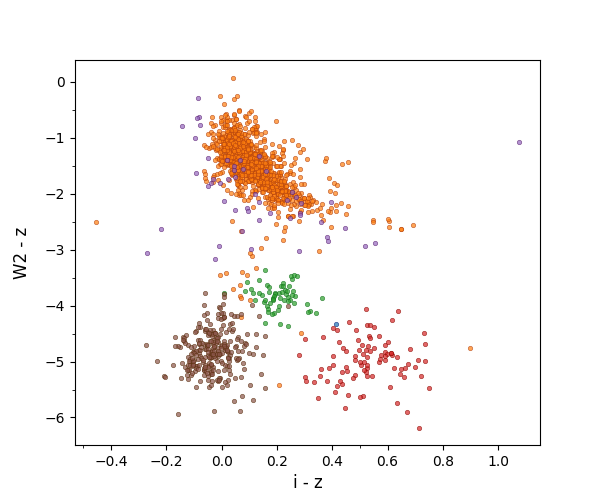

In [17]:
plot_color_color_diagram((('i_PStotal', 'z_PStotal'), ('W2mag', 'z_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

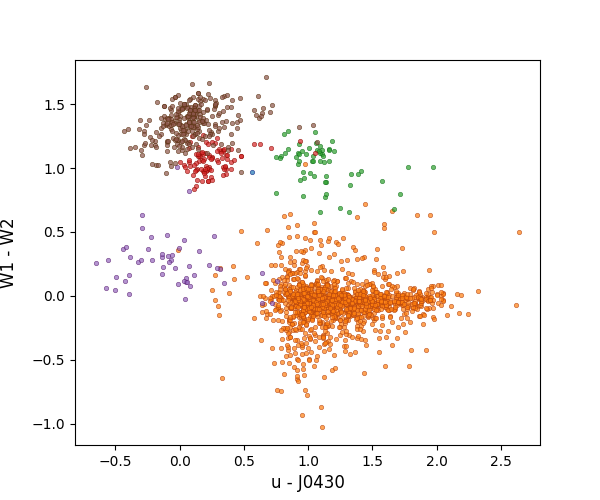

In [5]:
plot_color_color_diagram((('u_PStotal', 'J0430_PStotal'), ('W1mag', 'W2mag')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

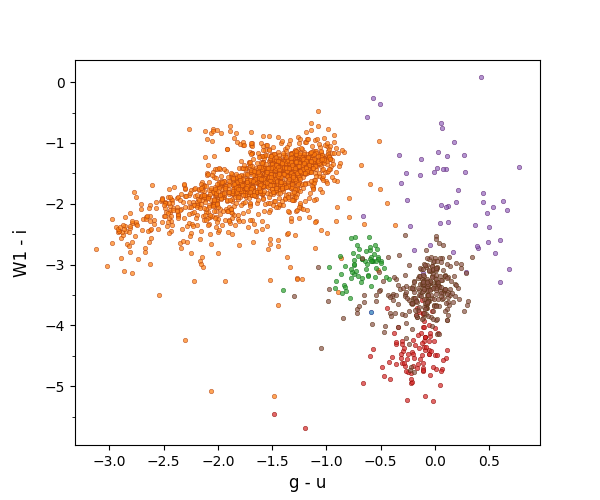

In [16]:
plot_color_color_diagram((('g_PStotal', 'u_PStotal'), ('W1mag', 'i_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

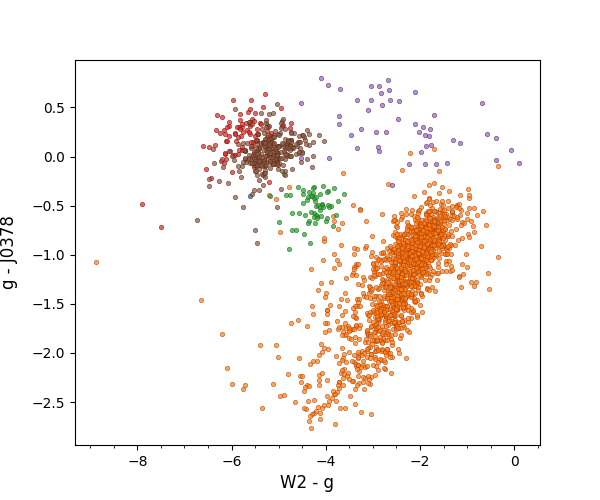

In [7]:
plot_color_color_diagram((('W2mag', 'g_PStotal'), ('g_PStotal', 'J0378_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

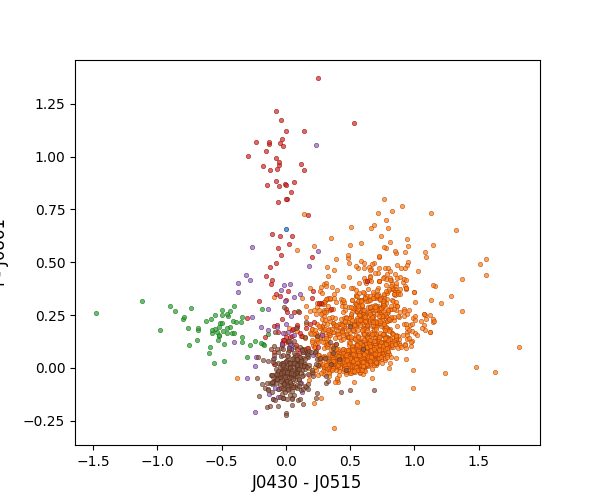

In [10]:
plot_color_color_diagram((('J0430_PStotal', 'J0515_PStotal'), ('i_PStotal', 'J0861_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

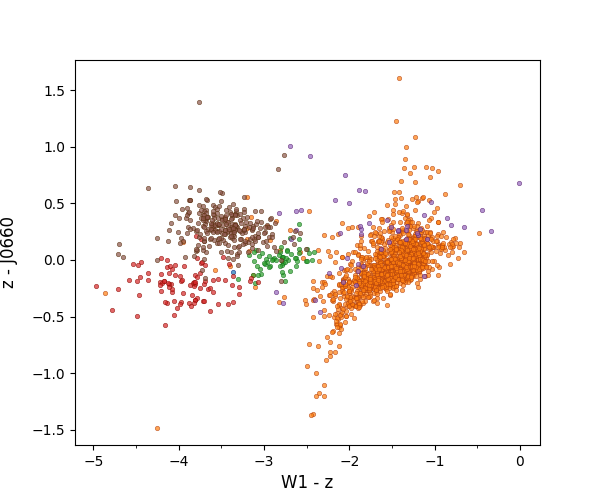

In [13]:
plot_color_color_diagram((('W1mag', 'z_PStotal'), ('z_PStotal', 'J0660_PStotal')))

Textarea(value='', description='Resultados:', layout=Layout(height='100px', width='100%'), placeholder='Pendie…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

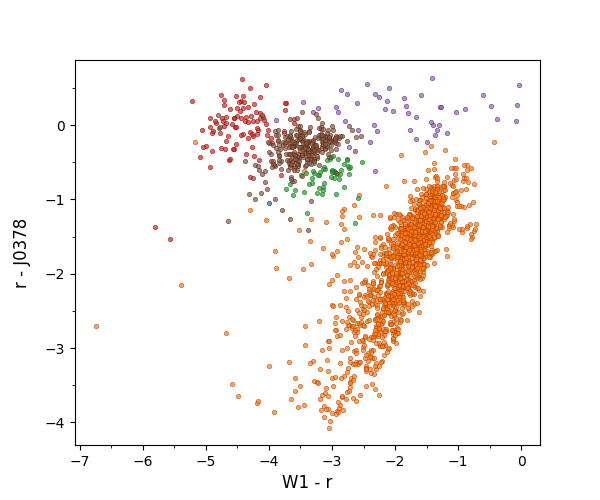

In [14]:
plot_color_color_diagram((('W1mag', 'r_PStotal'), ('r_PStotal', 'J0378_PStotal')))

## Documentación

### Función `open_csv_conc`

Esta función abre y concatena archivos CSV que coinciden con un patrón específico, excluyendo aquellos que contienen un patrón de exclusión en su nombre.

### Función `calculate_slope_intercept`

Esta función calcula la pendiente y el intercepto de una línea definida por dos puntos (x1, y1) y (x2, y2).

### Función `on_click_factory`

Esta función define los eventos de clic, selección, movimiento y liberación para manejar interacciones con líneas dibujadas en el gráfico.

### Función `plot_color_color_diagram`

Esta función crea un gráfico color-color para un par específico de columnas, permitiendo dibujar, mover y eliminar líneas en el gráfico.